# Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Loading Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Data preprocessing

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('int32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('int32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Data augmentation

In [4]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(x_train)

# CNN model creation

In [5]:
model = Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

# Model compilation

In [6]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

# Early stopping

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model training with data augmentation and early stopping

In [8]:
model.fit(datagen.flow(x_train, y_train, batch_size=128),
          epochs=30,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

Epoch 1/30


2023-05-16 23:53:42.513358: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


469/469 [==============================] - 10s 21ms/step - loss: 0.3884 - accuracy: 0.8801 - val_loss: 0.0740 - val_accuracy: 0.9774
Epoch 2/30
469/469 [==============================] - 10s 22ms/step - loss: 0.1396 - accuracy: 0.9567 - val_loss: 0.0424 - val_accuracy: 0.9862
Epoch 3/30
469/469 [==============================] - 10s 22ms/step - loss: 0.0949 - accuracy: 0.9703 - val_loss: 0.0391 - val_accuracy: 0.9868
Epoch 4/30
469/469 [==============================] - 10s 21ms/step - loss: 0.0778 - accuracy: 0.9763 - val_loss: 0.0330 - val_accuracy: 0.9891
Epoch 5/30
469/469 [==============================] - 10s 21ms/step - loss: 0.0677 - accuracy: 0.9791 - val_loss: 0.0295 - val_accuracy: 0.9894
Epoch 6/30
469/469 [==============================] - 10s 21ms/step - loss: 0.0578 - accuracy: 0.9821 - val_loss: 0.0288 - val_accuracy: 0.9913
Epoch 7/30
469/469 [==============================] - 10s 20ms/step - loss: 0.0522 - accuracy: 0.9840 - val_loss: 0.0238 - val_accuracy: 0.9925
Epo

# Model Evaluation

313/313 [==============================] - 1s 2ms/step
Test loss: 0.023823119699954987
Test accuracy: 0.9925000071525574
Precision: 0.9924300287787451
Recall: 0.9925304833120817
F1 Score: 0.9924682796165769


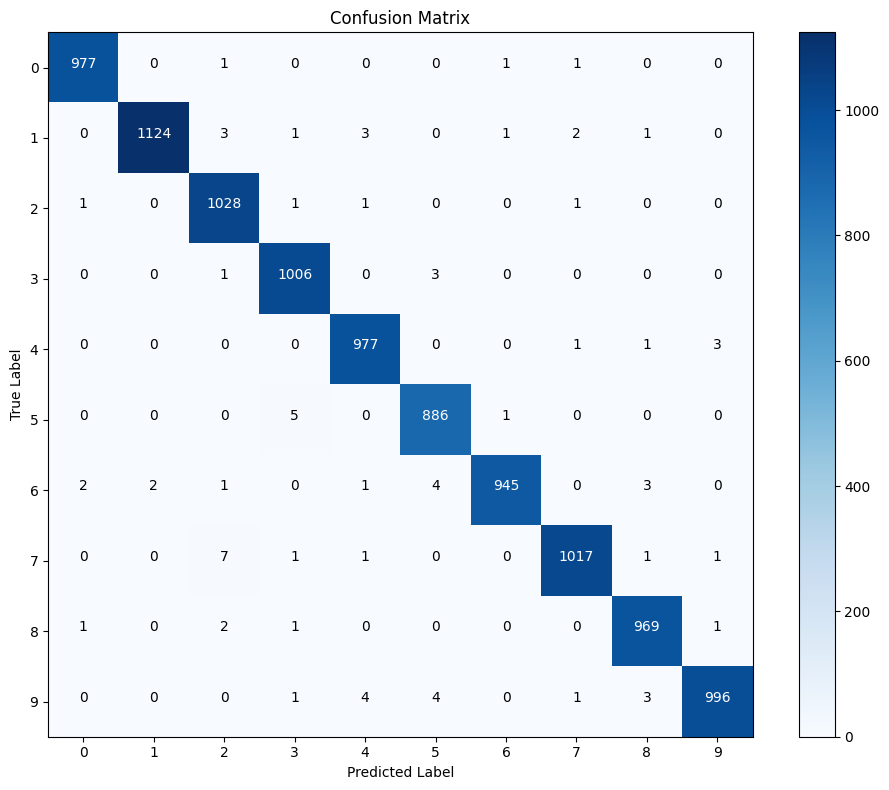

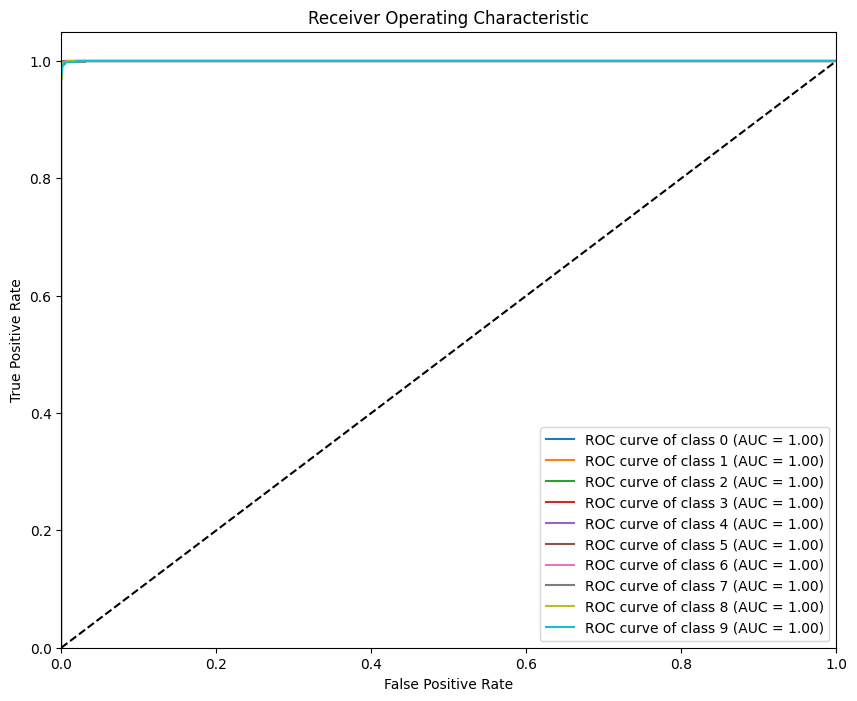

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Compute precision, recall, and F1 score
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.0
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()